## *Towards Deep Understanding: An Introductory Tutorial on Causal Inference*

#### [Serbian Machine Learning Workshop](https://workshops.eeml.eu/) part of the [EEML](https://www.eeml.eu/home) Workshop Series 2022

####### **Presenter:** Matej Zečević 

Feel free to visit: [matej-zecevic.de](https://matej-zecevic.de) for open-access articles on science and culture. This Code Tutorial will also be uploaded there after the live event at SMLW.

**Abstract:** In this practical session the attendee is going to explore concepts from causality in the formalized notion from Turing award winner Judea Pearl (key reference here is the book "Causality" 2009 Cambridge University Press, but we will also explore notions from subsequent literature as in "Elements of Causal Inference " 2017 from Peters et al. in MIT Press) in a machine learning context. These concepts involve reasoning about causal relations themselves (known as causal discovery) but also reasoning about causal effects (known as causal identification/estimation). To succeed in such an endeavour it takes not only data but also assumptions (or inductive biases) that can alleviate inference to reason about true causal relations exposed by the system under investigation, as famously put by Pearl himself the community must go beyond current machine learning which "amounts to only curve fitting". We will explore examples that make clear why this arguably harsh sentiment towards current practices in deep learning can find justification in formulable notions that make apparent why and how the field might continue to evolve towards the original dream of artificial intelligence. The attendee must not be afraid of exploring this growing field at the intersection of causality and machine learning at new since this practical will allow to follow from the ground-up with simple examples, yet leave room for cutting edge research revolving around modern models such as graph neural networks. The attendee will learn to recognize that deep learning has the potential to evolve towards deep understanding and hopefully this practical will motivate to engage in a community effort towards causal machine learning.

### Table of Content:

* **[1] On Why We Need Causality**
* **[2] Introducing Elements of Causal Reasoning**
    * [2.1] Consequence of Pearl's Causal Hierarchy
    * [2.2] Our Causal Representation of Choice: The Structural Causal Model
* **[3] How do we get the Graph? Onto Causal Discovery!**
* **[B] Bonus: We have the Graph. What do we do with it?**
    * [B.1] Complimenting the $do$-Calculus with Neural Networks
    * [B.2] Bounding Causal Effects from Causal Assumptions

Recommendation of Literature/References for Self-Study:
* Judea Pearl, [“Causality”](http://bayes.cs.ucla.edu/BOOK-2K/), Cambridge University Press, 2009.
* Peters et al., [“Elements of Causal Inference”](https://mitpress.mit.edu/books/elements-causal-inference), MIT Press, 2017.
* Jonas Peters [Lecture Series “Causality” on YouTube](https://www.youtube.com/watch?v=zvrcyqcN9Wo), MIT, 2017.
* Brady Neal’s [Online Course ”Introduction to Causal Inference”](https://www.bradyneal.com/causal-inference-course), 2020. 
* Elias Bareinboim [Lecture “Causal Data Science” on YouTube](https://www.youtube.com/watch?v=dUsokjG4DHc), 2019.

Since this tutorial provides code, we will have to use several libraries to help us compile the content of this tutorial and fix some preliminary setting. Below is the full set of dependencies, each explained via a comment.

In [319]:
# libraries for maths and data structures
import random
import numpy as np
import pandas as pd

# some general libraries
import utils
from string import ascii_uppercase

# visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# base settings for the plots and for reproducibility
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_palette("cubehelix")
np.random.seed(70522)
random.seed(70522)

### [1] On Why We Need Causality

On a simple example we will make clear why the Pearlian notion of Causality is crucial for next-generation learning systems, which we require to reason about settings outside their "comfort zone" i.e., outside the available data or in scenarios similar yet distinct of what is known.

The following example is based on Peters et al. 2016.

First, we load our data set which contains 200 samples of activities of two genes $A$ and $B$ recorded alongside a phenotype $P$.

In [326]:
df = pd.read_csv("Dataset-Example-Phenotype-and-Genes.csv", index_col=0)
df[["gene_A", "gene_B", "phenotype"]]

,gene_A,gene_B,phenotype
0,5.028408,3.423724,8.452133
1,4.601939,4.243262,8.845200
2,5.211323,0.944925,6.156248
3,4.797606,4.480183,9.277788
4,4.378072,4.631367,9.009438
...,...,...,...
195,6.511865,3.267862,9.779727
196,5.322205,3.310240,8.632445
197,3.625206,3.414847,7.040052
198,5.819953,2.985836,8.805789


Let's now visualize the data to get a first feel of which relations are present.

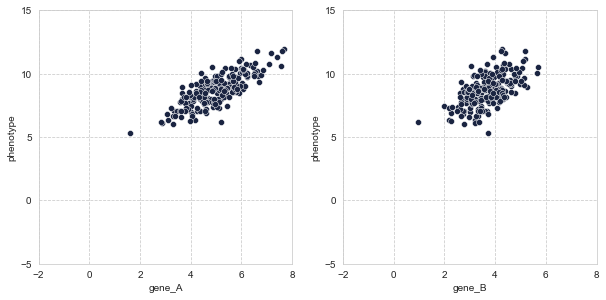

In [327]:
fig, axs = plt.subplots(1,2,figsize=(10,7))

x='gene_A'
y='phenotype'
sns.scatterplot(data=df, x=x, y=y, ax=axs[0])
axs[0].set_yticks(np.arange(0-5, 15+5, 5.0))
axs[0].set_xticks(np.arange(0-2, 8+2, 2.0))
axs[0].set_aspect(1./axs[0].get_data_ratio())

x='gene_B'
y='phenotype'
sns.scatterplot(data=df, x=x, y=y, ax=axs[1])
axs[1].set_yticks(np.arange(0-5, 15+5, 5.0))
axs[1].set_xticks(np.arange(0-2, 8+2, 2.0))
axs[1].set_aspect(1./axs[1].get_data_ratio())

plt.show()

We clearly observe a strong correlation between both $(A,P)$ and $(B,P)$.

Let's fit a simple machine learning model (Linear Regression) to our data now such that we can flexibly predict arbitrary inputs. 

Therefore, let's also visualize said model.

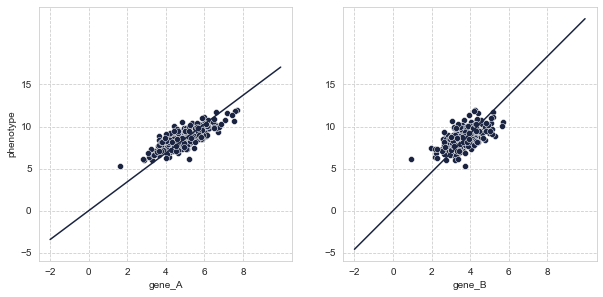

In [328]:
models = [LinearRegression(fit_intercept=False) for i in range(2)]

fig, axs = plt.subplots(1,2,figsize=(10,7), sharex='col', sharey='row')

for ind, x in enumerate(['gene_A', 'gene_B']):
    
    features = df[x][:,np.newaxis]
    targets = df[y]
    models[ind].fit(features, targets)
    prediction_intervall = np.arange(0-2, 8+2, 0.05)[:,np.newaxis]
    predictions = models[ind].predict(prediction_intervall)
    
    sns.scatterplot(data=df, x=x, y=y, ax=axs[ind])
    axs[ind].plot(prediction_intervall, predictions)
    axs[ind].set_yticks(np.arange(0-5, 15+5, 5.0))
    axs[ind].set_xticks(np.arange(0-2, 8+2, 2.0))
    axs[ind].yaxis.set_tick_params(labelbottom=True)
    axs[ind].set_box_aspect(1.)

plt.show()

Great. We have a model of our data now, and looking at the fit, we have found the bist linear model for the job.

#### Question Time

We want to find out more about the relation between $A, B$ and $P$. Therefore, we decide to conduct two experiments in the biology lab that initially collected our data, since they have the capabilities to do so. The experiments will set each the activity of a gene to zero (we will denote this with $do(A=0)$ and $do(B=0)$) and record the data for us, respectively.

**Q: What can we expect from such an experimental setup?**

**A:** Well, we have a trained machine learning model. Why not just ask it what it thinks on the input $A=0$?

Therefore, in both cases we'd expect the value predicted by our two models when we set our input to 0 i.e., $f(0)$ where $f$ is our learned model --- which in this case evaluates to approx. 0 in both cases.

Our answer, we expect the phenotype to react to our experiments and become 0.

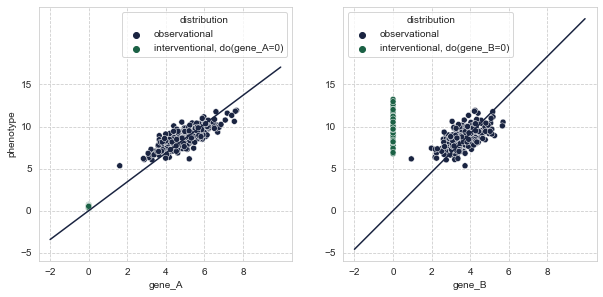

In [329]:
df_pool1 = pd.read_csv("Dataset-Example-Phenotype-and-Genes-Pool-1.csv") # loading newly collected experimental data
df_pool2 = pd.read_csv("Dataset-Example-Phenotype-and-Genes-Pool-2.csv")

dfs = [df_pool1, df_pool2]

fig, axs = plt.subplots(1,2,figsize=(10,7), sharex='col', sharey='row')
for ind, x in enumerate(['gene_A', 'gene_B']):
    
    features = df[x][:,np.newaxis]
    targets = df[y]
    models[ind].fit(features, targets)
    prediction_intervall = np.arange(0-2, 8+2, 0.05)[:,np.newaxis]
    predictions = models[ind].predict(prediction_intervall)
    
    sns.scatterplot(data=dfs[ind], x=x, y=y, ax=axs[ind], hue='distribution')
    axs[ind].plot(prediction_intervall, predictions)
    axs[ind].set_yticks(np.arange(0-5, 15+5, 5.0))
    axs[ind].set_xticks(np.arange(0-2, 8+2, 2.0))
    axs[ind].yaxis.set_tick_params(labelbottom=True)
    axs[ind].set_box_aspect(1.)

plt.show()

Well, this is unexpected.. (not in the scope of this presentation, but as a genuine result.)

The experimental results provided to us hold accurately in one case but are *completely off in the other*.

The question arises **Why?** (this might also be one of the reasons J. Pearl named his 2018 book "The Book of Why".)


**We conclude that machine learning using *only data* is not sufficient, even in this simple setting - we could not have predicted correctly, the only correct answer was "I don't know". Therefore, we need to go *beyond*!**

### [2] Introducing Elements of Causal Reasoning

One possible explanation for what we just observed in the previous section is that the underlying data generating process (i.e., the physical reality that governs the relation of $A, B$ and $P$) is somehow different between the two pairs $(A,P)$ and $(B,P)$ in that $A$ changes $P$ but $B$ does not change $P$.

Such a notion of *change* is what is being captured by the Pearlian notion of Causality.

I.e., we say $A$ causes $P$ but $B$ does not cause $P$.

Now, you might ask, how did they corrolate ($B$ and $P$) so strongly in the first place?

Well, the simple answer is, that $B$ and $P$ are affected by a common cause, a (hidden) *confounder*.

Graphically, we can depict this intution as
$$
A\rightarrow P
$$
and
$$
B\leftarrow C \rightarrow P
$$
where $C$ is said hidden confounder. (Hidden, because we only now started hypothesizing that it must exist.)

To summarize, we needed to go "outside" our data and model choice to the *assumptions* over what generated our data, to finally come up with a distinction of the previous two settings, which otherwise looked indiscernible.

#### [2.1] Consequence of Pearl's Causal Hierarchy

The experiments that we have conducted (or rather the biology lab) are known as *interventions* in causality.

And by observing this interventional data, we were able to conclude the graphs underlying our data.

Let's try to capture this idea from ground-up, with simple toy data that we will generate ourselves.

We will call this "base" data, *observational* data.

Let
$$
A = U_A
$$
and
$$
B = A \wedge U_B
$$
with $\wedge$ being logical and, and $U_A,U_B$ be independent and identically distributed, say, just a random, fair coin flip $\mathcal{B}(0.5)$.

We use $U$ to denote something "**U**nmodelled" (things we forgot, don't know about or simply see as noise).

In [330]:
def toy_data(N):
    """
        N is the number of samples
    """
    U_A = np.random.binomial(1,.5,(N,1))
    U_B = np.random.binomial(1,.5,(N,1))
    A = U_A
    B = np.logical_and(A, U_B)
    return np.hstack((A, B))

Let's simulate our data now by sampling the noise terms and instantiating them.

This gives us our observational distribution.

Var(A)=0.25, Var(B)=0.19,


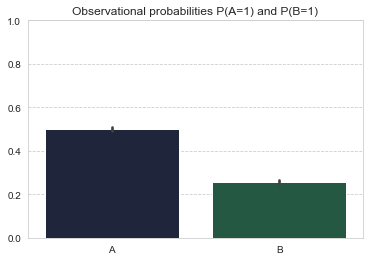

In [338]:
df = pd.DataFrame(toy_data(N=10000), columns=["A","B"])

print(f"Var(A)={np.var(df['A']):.2f}, Var(B)={np.var(df['B']):.2f},")

sns.barplot(data=df)
plt.ylim(0,1)
plt.title("Observational probabilities P(A=1) and P(B=1)")
plt.show()

As expected, $P(A)=0.5$, whereas $P(B)=0.25$ since we can see it as two subsequent fair coin flips.

Now, as before, we would like to do an experiment, an intervention, but this time *we control the data*, so to perform an intervention $do(A=1)$ we simply "hardcode" $A$ to be assigned $1$.

Var(A)=0.00, Var(B)=0.25,


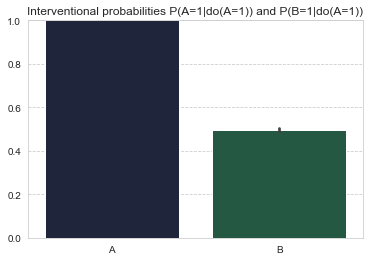

In [337]:
def toy_data_int_A(N):
    """
        N is the number of samples
    """
    U_A = np.random.binomial(1,.5,(N,1))
    U_B = np.random.binomial(1,.5,(N,1))
    A = np.ones((N,1))
    B = np.logical_and(A, U_B)
    return np.hstack((A, B))

df_int_A = pd.DataFrame(toy_data_int_A(N=10000), columns=["A","B"])

print(f"Var(A)={np.var(df_int_A['A']):.2f}, Var(B)={np.var(df_int_A['B']):.2f},")

sns.barplot(data=df_int_A)
plt.ylim(0,1)
plt.title("Interventional probabilities P(A=1|do(A=1)) and P(B=1|do(A=1))")
plt.show()

As expected, since $A$ changed and $A$ is a cause of $B$ by definition, we see a change in $B$ i.e., $P(B|do(A=1))=0.5$.

Interestingly, this intervention coincides with the *conditional* probability distribution $p(B|A=1)$ which we get by rules of probability theory $p(B|A)=\frac{p(A,B)}{p(A)}$ i.e., we simply look at all $B$'s where $A=1$. (Note, that decimal differences are due to sampling, in the limit of $N\rightarrow \infty$ samples we will have equality.)

In [335]:
print(f'Conditional Probability P(B=1|A=1)={sum(df.iloc[np.where(df["A"]==1)]["B"])/len(df.iloc[np.where(df["A"]==1)]):.2f}')
print(f'Interventional Probability P(B=1|do(A=1))={sum(df_int_A["B"])/len(df_int_A):.2f}')

Conditional Probability P(B=1|A=1)=0.50
Interventional Probability P(B=1|do(A=1))=0.50


Generally, interventions are different from observations and thus conditioning (i.e., the above example was a special case since $A$ is the only cause of $B$) as this simple example where we intervene on $B$ shows.

Var(A)=0.25, Var(B)=0.00,


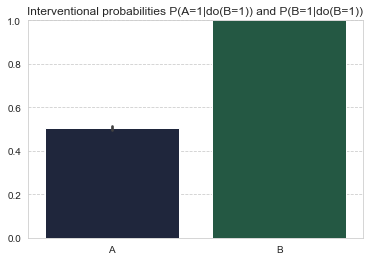

Conditional Probability P(A=1|B=1)=1.00
Interventional Probability P(A=1|do(B=1))=0.51


In [339]:
def toy_data_int_B(N):
    """
        N is the number of samples
    """
    U_A = np.random.binomial(1,.5,(N,1))
    U_B = np.random.binomial(1,.5,(N,1))
    A = U_A
    B = np.ones((N, 1))
    return np.hstack((A, B))

df_int_B = pd.DataFrame(toy_data_int_B(N=10000), columns=["A","B"])

print(f"Var(A)={np.var(df_int_B['A']):.2f}, Var(B)={np.var(df_int_B['B']):.2f},")

sns.barplot(data=df_int_B)
plt.ylim(0,1)
plt.title("Interventional probabilities P(A=1|do(B=1)) and P(B=1|do(B=1))")
plt.show()

print(f'Conditional Probability P(A=1|B=1)={sum(df.iloc[np.where(df["B"]==1)]["A"])/len(df.iloc[np.where(df["B"]==1)]):.2f}')
print(f'Interventional Probability P(A=1|do(B=1))={sum(df_int_B["A"])/len(df_int_B):.2f}')

As predicted, $P(B|A)\neq P(B|do(A))$ since in the former we observe $B$ (i.e., the noise terms $U_i$ get instantiated and thus fixed) whereas in the latter we actually change the cause of $B$ by deciding that it now corresponds to a constant. The graph changes thus to the disconnected graph
$$
A \not\rightarrow B.
$$

So, knowing $B$ was $1$ implies that $A$ was also $1$ whereas setting $B$ to $1$ renders $B$ independent of $A$.

To summarize, we can ask these questions:

* **Q1 (observational):** What is the probability of $B$ being $1$, formally $P(B=1)$?
* **Q2 (conditional):** I know that $A$ is 1, so how does this change my belief in $B$ being $1$, formally $P(B=1|A=1)$?
* **Q3 (interventional):** We have done an experiment where we set $A$ to 1, what is our belief in $B$ being $1$, formally $P(B=1|do(A=1))$?

As you might have thought of yourself, we can also combine Q2 and Q3 to form a third type of reasoning, that is, we might ask *retrospectively*:

**Q4 (counterfactual)** We have seen both $A,B$ being 0, but if we had changed $B$ to $1$ what are the chances $A$ would have been $1$, formally $P(A=0|do(B=1),A=1,B=0)$?

To give an example for Q4, imagine $A=1$ denoting having a headache and $B=1$ denoting taking an aspirin, then Q4 essentially asks whether we would have cured our headache if we had taken the aspirin since we actually ended up having headache after not taking an aspirin.

#### [2.2] Our Causal Representation of Choice: The Structural Causal Model

In the last section, we took control in our hand and discovered the different notions of reasoning (observational, interventional, counterfactual) from ground-up. Actually, we also used already our representation of choice --- the **Structural Causal Model**, SCM for short.

The description of how $A, B$ are computed are known as structural equations.

More formally, we have an SCM given by

$$
\mathcal{M}=\langle \mathbf{V}, \mathbf{U}, \mathcal{F}, P(\mathbf{U}) \rangle
$$

where $\mathbf{V}$ are our endogenous (observed) variables (e.g. $\mathbf{V}=\{A,B\}$)

where $\mathbf{U}$ are our exogenous (hidden) variables (e.g. $\mathbf{U}=\{U_A,U_B\}$)

where $\mathcal{F}$ are our structural equations (e.g. $\mathcal{F}=\{f_A(U_A)=U_A,f_B(A,U_B)=A+U_B\}$)

and finally where $P(\mathbf{U})$ is a product distribution (our $\mathbf{U}$ are independent).

Again, remember that this is nothing new --- we already discovered it, it just the general formulation!

Also, remember that $\mathcal{M}$ implies a graph structure $G:=G(\mathcal{M})$, which in the cases we consider here, we can simply read off from the structural equations in $\mathcal{F}$.

For example, as before, let $\mathcal{M}=\langle \{A,B\}, \{U_A,U_B\}, \{f_A(U_A)=U_A,f_B(A,U_B)=A+U_B\}, \mathcal{B}(0.5)*\mathcal{B}(0.5) \rangle$ the graph is

$$
A\rightarrow B
$$

**To conclude, the SCM represents our causal system and it is more than just a graph, it is actually a *simulator* that can generate our data and by that implies a graph.**

### [3] How do we get the Graph?

This is the question of concern now. 

We have seen in Section [1] why causality is needed in machine learning by observing a hopeless situation, where regular machine learning fails.

We have seen in Section [2] all key elements of reasoning, and how they connect to what we already know from regular probability theory.

But now that we know what an SCM is, how do we get it, or *how do we even get only the graph?*

In the following, we will use show the application of two different methods from the causal discovery literature.

* The first algorithm comes from the family of constraint-based methods. The first ever proven both sound and complete causal discovery algorithm, **Fast Causal Inference** (Spirtes et al., 2000), FCI for short. FCI works both fast and gives guarantees, however, comes at the lack of being able to discern graphs which share a notion of equivalence (i.e., we usually won't get the exact, unique graph of our problem at hand).

  The algorithm exploits *conditional independences* found in the data to construct the graph by adhering to what is known as $d$-separation, a graphical criertion which establishes an equivalence to the former by the Markov condition and faithfulness, formally $A \underset{P}{\perp} B | C \iff A \underset{G}{\perp} B | C$ where an independence in $P$ is equivalent to a separation in graph $G$. 

Be assured, we need not go in the details here, but we will simply explore our original biology example using FCI.

* The second algorithm is a more recent one that disconnects from causal guarantees (i.e., is really concerned with evaluating sensible structures) but is very effective, NOTEARS (Zheng et al. 2018), NT for short. Unfortunately, the algorithm scales cubically in the number of dimensions $d, \mathcal{O}(d^3)$ rendering it restrictive but it offers a complete continuous-optimization characterization of the structure learning problems.

  The algorithm optimizes the mean-squared error (MSE) over DAGs, where a DAG is guaranteed via convergence to an acylicity constraint.

Again, be assured, we need not go in the details here, but we will also explore our original biology example using NT.

In [340]:
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.search.ConstraintBased.PC import pc
from linear import notears_linear

def graph_induction(D, method):

    if method == "notears":
        G_pred = notears_linear(D, lambda1 = .1, loss_type = 'l2')
    elif method == "fci":
        G_pred = fci(D, verbose=False)
        G_pred = G_pred[0].graph

    return G_pred

Let's load our data again. Note that we are going to only look at our observational data i.e., the data which originally did not help us discern the causal system, since we did not ask for a causal model. That is, we will try to find the true causal graph of $B\leftarrow C\rightarrow P$ just from data points. This time around we will asumme that we observe the confounder $C$ (but we don't know yet whether it is actually a confounder, since of course, we want to know the graph now).

We will consider an alternate version of our data set in which we know the underlying functions to be non-linear, this will render our causal structure *identifiable*.

In [343]:
df = pd.read_csv("Dataset-Example-Phenotype-and-Genes-Nonlinear.csv")

df = pd.DataFrame(np.hstack((confounder, gene_A, gene_B, phenotype)), 
                  columns=['confounder', 'gene_A', 'gene_B', 'phenotype'])
df['distribution'] = ['observational' for _ in range(len(df))]

df = df.loc[:,["confounder", "gene_B", "phenotype"]]
df

,confounder,gene_B,phenotype
0,-0.537672,-0.155436,-0.536190
1,0.208107,0.009013,0.228719
2,0.979998,0.941186,1.602635
3,2.277776,11.817702,2.287479
4,1.212762,1.783719,3.323583
...,...,...,...
995,-0.991889,-0.975865,-0.597651
996,0.609639,0.226578,0.890405
997,0.201669,0.008202,2.279240
998,-0.676270,-0.309287,-0.595883


In [344]:
D = df.to_numpy()

G_pred_fci = graph_induction(D, method="fci")
G_pred_nt = graph_induction(D, method="notears")

Starting Fast Adjacency Search.



Finishing Fast Adjacency Search.

Not using Matrix Decomposition, directly estimating W.



<Figure size 432x288 with 0 Axes>

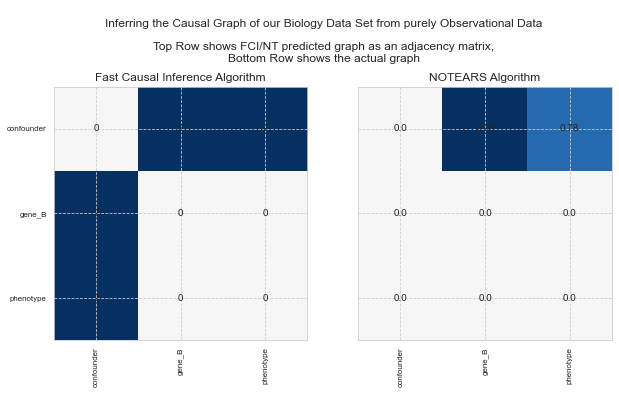

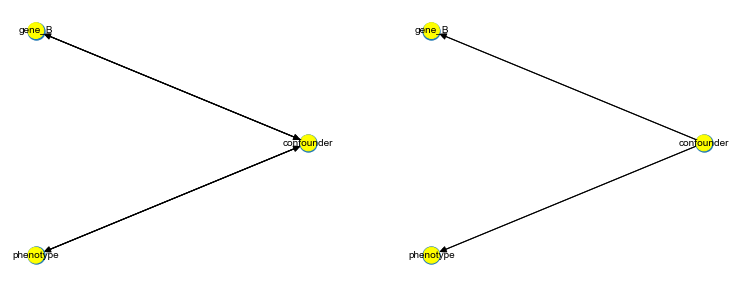

In [348]:
dims = G_pred.shape[0]
dict_visualization = {
    "Fast Causal Inference Algorithm": G_pred_fci,
    "NOTEARS Algorithm": G_pred_nt,
}

sharex = sharey = True
experiment_description = f'''
Inferring the Causal Graph of our Biology Data Set from purely Observational Data\n
Top Row shows FCI/NT predicted graph as an adjacency matrix,
Bottom Row shows the actual graph
'''
suptitle = f'{experiment_description}'

commonlabel = list(df.columns)
utils.plot_all_individual(list(dict_visualization.values()),
                    list(dict_visualization.keys()),
                    suptitle=suptitle,
                    alt_form=(1,2),
                    alt_size=(10,6),
                    sharex=sharex,
                    sharey=sharey,
                    commonlabel=commonlabel)

dict_cyc_vis = dict_visualization
utils.plot_digraphs_and_cycles(list(dict_cyc_vis.values()), list(dict_cyc_vis.keys()), commonlabel,
                    alt_size=(13,5), arrowsize=14, font_size=10, node_size=250, no_cycles=True)

As expected, both algorithms identify the structure, but FCI only up to Markov Equivalence whereas NOTEARS manages to find the exact causal graph (however, there is no guarantee --- beginner's luck you might call it here).

**To conclude we can use the available data in different, creative ways to find out about its origin, that is, the data generating SCM's causal graph - amazing!**

#### Shoutout to the great organizers of this wonderful workshop, they have done an amazing job! `\(*.*)/`

Starting from the later afternoon, I will be available to answer any questions.
Also, do not hesitate to contact me via mail, thanks for your time.

### [4] Bonus: We have the Graph. What do we do with it?

Great. We have learned so much already.

We have seen the different phenomena, seen how to formalize it within the SCM, and now even showed how we can get the underlying graph of the SCM --- *without actually performing any interventions ourselves, just from passive data.*

Having the graph, as we know from Section [2] though, is only underlying the SCM.

But what can we do with the graph? We can train a machine learning model to *effectively learn an SCM*.

In the following, we will not actually learn an SCM in the interest of time and space, however, we will assume an SCM given (as before when we actually created one), and will ask the question.

***Once we have the SCM, what can we answer?***

Well, having the SCM means having the capabilities of producing the elements of reasoning from Section [2].

Most often, however, we are interested in a *causal effect* i.e., how does $A$ really *influence* $B$?

Formally, we can capture this with the Average Causal Effect (ACE), in the case of say binary $A,B$ we have

$$
ACE(A,B):= \mathbb{E}[A|do(B=1)]-\mathbb{E}[A|do(B=0)] = P(A=1|do(B=1))-P(A=1|do(B=0)).
$$

As you recognize, whether we have a learned SCM or the actual SCM, the ACE simply defines a difference between two different interventional distributions which we can easily acquire having the former. Done.

#### [B.1] Complimenting the $do$-Calculus with Neural Networks

*But say we did not have the SCM, only the graph. Then we don't know how to get say $P(A|do(B))$?*

The surprising answer: No, we can *identify* $P(A|do(B))$ from purely observational data using our knowledge on the graph.

The previous section covered *structure identification* whereas this is known as *effect identification*.

The celebrated tool for this is Pearl's own $do$-calculus, which is a graphical-algebraic tool proven to be *complete* i.e., any effect tha can be identified will get an answer from $do$-calculus and if it cannot be identified, then $do$-calculus will also let you know.

Let us look at the following example.

The SCM $\mathcal{M}$ is given with the structural equations (with standard normal noise terms)

$$
\begin{align}
A &= f_A(U_A) = U_A \\
B &= f_B(A,U_B) = A^2 + U_B \\
C &= f_R(A,B,U_C) = A^2 + B^3 + U_C
\end{align}
$$

then the implied graph is $A\rightarrow \{B,C\}; B\rightarrow C$ and $do$-calculus will reveal that

$$
p(C|do(B))=\int p(C|A,B)p(A) dA
$$

where the r.h.s. are all observational, probabilistic terms that we can learn from empirical data following $p(A,B,C)$ (!) and we call this r.h.s. the *estimand* (an observational estimand of a causal quantity).

More specifically, we can learn a neural net (or e.g. a sum-product network for tractability and probability guarantees) to estimate the components of the estimand and thus answer our causal query!

Let's define the above SCM and then train a simple neural network.

Var(A)=1.01, Var(B)=3.17, Var(C)=143.39


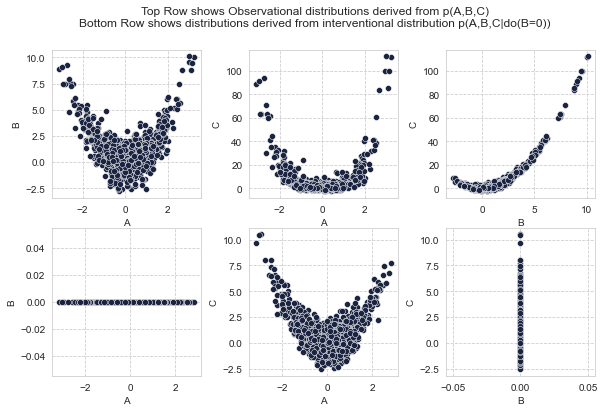

In [290]:
def toy_data(N):
    """
        N is the number of samples
    """
    U_A = np.random.normal(0,1,(N,1))
    U_B = np.random.normal(0,1,(N,1))
    U_C = np.random.normal(0,1,(N,1))
    A = U_A
    B = A**2 + U_B
    C = A**2 + B**2 + U_C
    return np.hstack((A, B, C))
df = pd.DataFrame(toy_data(N=1000), columns=["A","B", "C"])

print(f"Var(A)={np.var(df['A']):.2f}, Var(B)={np.var(df['B']):.2f}, Var(C)={np.var(df['C']):.2f}")

def toy_data_int_B0(N):
    """
        N is the number of samples
    """
    U_A = np.random.normal(0,1,(N,1))
    U_B = np.random.normal(0,1,(N,1))
    U_C = np.random.normal(0,1,(N,1))
    A = U_A
    B = np.zeros((N,1))
    C = A**2 + B**2 + U_C
    return np.hstack((A, B, C))
df_int_B0 = pd.DataFrame(toy_data_int_B0(N=1000), columns=["A","B", "C"])


fig,axs = plt.subplots(2,3,figsize=(10,6))
sns.scatterplot(data=df, x='A', y='B', ax=axs[0,0])
sns.scatterplot(data=df, x='A', y='C', ax=axs[0,1])
sns.scatterplot(data=df, x='B', y='C', ax=axs[0,2])
sns.scatterplot(data=df_int_B0, x='A', y='B', ax=axs[1,0])
sns.scatterplot(data=df_int_B0, x='A', y='C', ax=axs[1,1])
sns.scatterplot(data=df_int_B0, x='B', y='C', ax=axs[1,2])
for a in axs.flatten():
    a.set_box_aspect(1.)
plt.suptitle("Top Row shows Observational distributions derived from p(A,B,C)\nBottom Row shows distributions derived from interventional distribution p(A,B,C|do(B=0))")
plt.show()

We are going to try to compute the interventional distribution $p(C|do(B=0))$ (the lower three plots) using our estimand.

We will fit two separate neural nets, one for $p(C|B,A)$ and one for $p(A)$.

In [291]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

Epoch: 100%|██████████| 100/100 [00:09<00:00, 10.25it/s]


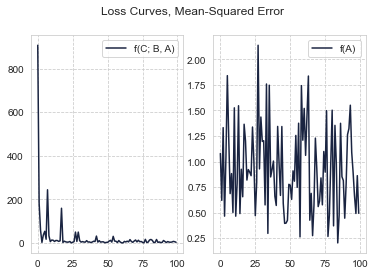

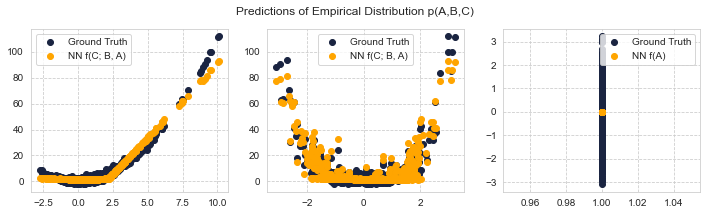

In [292]:
class NeuralNetwork(nn.Module):
    """
        Simple Multi-Layer Perceptron, MLP with one hidden layer
    """

    def __init__(self, len_inputs):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(len_inputs, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net_c_given_ba = NeuralNetwork(len_inputs=2)
net_a = NeuralNetwork(len_inputs=1)
neural_nets = [(net_c_given_ba, "f(C; B, A)"), (net_a, "f(A)")]

class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X.float()
        self.y = y.float()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.y[i]

dataset_c_given_ba = Dataset(torch.tensor(df[["B", "A"]].values), torch.tensor(df["C"])[:,None])
dataset_a = Dataset(torch.ones_like(torch.tensor(df["A"])[:,None]), torch.tensor(df["A"])[:,None])
    
dl_c_given_ba = torch.utils.data.DataLoader(dataset_c_given_ba, batch_size=10, shuffle=True, num_workers=1)
dl_a = torch.utils.data.DataLoader(dataset_a, batch_size=10, shuffle=True, num_workers=1)
dataloaders = [dl_c_given_ba, dl_a]

criterion = nn.MSELoss()

epochs = 100
results = {}
for ind, (net,desc) in enumerate(neural_nets):
    loss_curve = []
    optimizer = optim.SGD(net.parameters(), lr=0.0001)
    for e in tqdm(range(epochs), desc="Epoch"):
        current_loss = 0.
        for i, data in enumerate(dataloaders[ind]):

            inputs, targets = data
            inputs = inputs[:, None]
            targets = targets[:, None]

            optimizer.zero_grad()
            output = net(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()

        loss_curve.append(loss)
    results.update({desc: loss_curve})

fig, axs = plt.subplots(1,2, sharex=True)
axs[0].plot(range(epochs), results["f(C; B, A)"], label="f(C; B, A)")
axs[1].plot(range(epochs), results["f(A)"], label="f(A)")
axs[0].legend()
axs[1].legend()
plt.suptitle("Loss Curves, Mean-Squared Error")
plt.show()

fig, axs = plt.subplots(1,3, figsize=(12,3))
axs[0].scatter(dataset_c_given_ba.X[:,0],dataset_c_given_ba.y,label="Ground Truth")
axs[0].scatter(dataset_c_given_ba.X[:,0],net_c_given_ba(dataset_c_given_ba.X).detach().numpy(),label="NN f(C; B, A)", color="orange")
axs[1].scatter(dataset_c_given_ba.X[:,1],dataset_c_given_ba.y,label="Ground Truth")
axs[1].scatter(dataset_c_given_ba.X[:,1],net_c_given_ba(dataset_c_given_ba.X).detach().numpy(),label="NN f(C; B, A)", color="orange")
axs[2].scatter(dataset_a.X,dataset_a.y,label="Ground Truth")
axs[2].scatter(dataset_a.X,net_a(dataset_a.X).detach().numpy(),label="NN f(A)", color="orange")
axs[0].legend()
axs[1].legend()
axs[2].legend()
plt.suptitle("Predictions of Empirical Distribution p(A,B,C)")
plt.show()

As we see, our neural net is capable of approximating the content of the desired distribution. However, note that here we just considered a simple, discriminative setting i.e., if we actually want to have the distribution (capable of simulation), then we should deploy our Neural Net(s) within e.g. Normalizing Flows (NF for short). If we were to use graph neural networks (GNN for short), then a natural candidate would be the variational graph-autoencoder (VGAE for short). But this we keep for another tutorial.

##### On another note, the amazing [Petar Veličković](https://petar-v.com/) will hold the second tutorial tomorrow on GNNs. We actually have some joint work, joining the forces of Causality and GNNs, so if you are interested, then please have a look at: https://matej-zecevic.de/2021/255/relating-GNN-to-SCM

#### [B.2] Bounding Causal Effects from Causal Assumptions

In this final (bonus) subsection of this tutorial, we will consider an advanced topic in causal inference, where we are again given only structural knowledge on the graph alongside our data, and we try to *bound* the causal effect.

The following example is based on Zhang & Bareinboim 2017, ZB17 in short.

We define a non-Markovian SCM i.e., $U1$ is both parent to $X$ and $Y$, as

$$
\mathcal{M} = \langle \mathbf{U},\mathbf{V},\mathcal{F},P(\mathbf{U}) \rangle
$$

with

$$\mathbf{U}=\{U_1, U_2\}, \mathbf{V}=\{X, Y\}, \mathcal{F}=\{f_X=U_1, f_Y=X\oplus U_1 \oplus U2\}$$

and $P(\mathbf{U})=P(U_1)*P(U_2)$ with $P(U_1)=P(U_2)\sim B(.9)$, where $\oplus$ denotes logical xor.

In [363]:
N = int(1e7)
p1 = p2 = 0.9

def SCM(N,p1,p2):

    # SCM definition as above
    U1 = np.random.binomial(1, p1, size=N)
    U2 = np.random.binomial(1, p2, size=N)
    X = U1
    Y = np.logical_xor(np.logical_xor(X, U1), U2)
    
    #reshape
    X = X.reshape(-1,1)
    Y = Y.reshape(-1,1)
    D = np.hstack((X,Y)) # data stack
    
    return D

D = SCM(N, p1, p2) # this is the observational data
df = pd.DataFrame(D, columns=["X","Y"])

Now, let's compute all the probabilities $p_{ij}:=P(X=i, Y=j)$ of interest.

In [364]:
def joint_probs(df, N):

    p00 = len(df[(df.X == 0) & (df.Y == 0)])
    p01 = len(df[(df.X == 0) & (df.Y == 1)])
    p10 = len(df[(df.X == 1) & (df.Y == 0)])
    p11 = len(df[(df.X == 1) & (df.Y == 1)])

    ps = [p00, p01, p10, p11]
    ps = [x/N for x in ps]
    
    return ps

ps = joint_probs(df, N)

assert(np.allclose(sum(ps), 1.))

print(f'p(X=0,Y=0)={ps[0]:.3f}\np(X=0,Y=1)={ps[1]:.3f}\np(X=1,Y=0)={ps[2]:.3f}\np(X=1,Y=1)={ps[3]:.3f}\n')

p(X=0,Y=0)=0.010
p(X=0,Y=1)=0.090
p(X=1,Y=0)=0.090
p(X=1,Y=1)=0.810



Next we will check their precise numbers regarding causal effect $\mu_x = \mathbb{E}[Y|do(x)]$.
Obviously, for the non-Markovian variant (where $U_1$ is a confounder, but note observed!) the effect is not
identifiable, meaning that we can have another SCM $\mathcal{M}'$ which has a different $\mu_x$.

First, we will intervene $\mathcal{M}$ to create $\mathcal{M}'$.

Second, we simulate $\mathcal{M}'$ to get to the probabilities.

In [365]:
def SCM_intervened(N,p1,p2, interv):

    U1 = np.random.binomial(1, p1, size=N)
    U2 = np.random.binomial(1, p2, size=N)
    X = np.repeat(interv, N)
    Y = np.logical_xor(np.logical_xor(X, U1), U2)
    
    #reshape
    X = X.reshape(-1,1)
    Y = Y.reshape(-1,1)
    D = np.hstack((X,Y)) # data
    
    return D

D_i0 = SCM_intervened(N, p1, p2, interv=0) # this is intervened do(X=0)
D_i1 = SCM_intervened(N, p1, p2, interv=1)

ps_i0 = joint_probs(pd.DataFrame(D_i0, columns=["X","Y"]), N)
ps_i1 = joint_probs(pd.DataFrame(D_i1, columns=["X","Y"]), N)

assert(np.allclose(sum(ps_i0), 1.))
assert(np.allclose(sum(ps_i1), 1.))

print(f'Intervention do(X=0):\n p(X=0,Y=0)={ps_i0[0]:.3f}\np(X=0,Y=1)={ps_i0[1]:.3f}\np(X=1,Y=0)={ps_i0[2]:.3f}\np(X=1,Y=1)={ps_i0[3]:.3f}\n')
print(f'Intervention do(X=1):\n p(X=0,Y=0)={ps_i1[0]:.3f}\np(X=0,Y=1)={ps_i1[1]:.3f}\np(X=1,Y=0)={ps_i1[2]:.3f}\np(X=1,Y=1)={ps_i1[3]:.3f}\n')


Intervention do(X=0):
 p(X=0,Y=0)=0.820
p(X=0,Y=1)=0.180
p(X=1,Y=0)=0.000
p(X=1,Y=1)=0.000

Intervention do(X=1):
 p(X=0,Y=0)=0.000
p(X=0,Y=1)=0.000
p(X=1,Y=0)=0.180
p(X=1,Y=1)=0.820



And indeed our result is correct, if you look at what we have just computed.

Remember $\mu_x = \mathbb{E}[Y|do(X=x)] = \sum_y y*p(Y|do(X=x))$. Since $y\in\{0,1\}$ we have that $\mu_x = p(Y=1|do(X=x))$

And $\mu_0 = 0.18$ are $\mu_1 = 0.82$ respectively --- these are our _ground truth answers_ in this case.


Next, we start looking into the actual interesting stuff namely the bounds. We don't have the intervened SCM $\mathcal{M}'$ actually (we know it now just for the sake of tutorial) of course but only an empirical part of $P_{\mathcal{M}}(X,Y)$.

The bound in ZB17 is given by $$\mathbb{E}[Y|do(X=0)] \geq l := p_{01}, \quad \mathbb{E}[Y|do(X=1)] \geq l := p_{11}$$ 

and 

$$\mathbb{E}[Y|do(X=0)] \leq h := l + p_{10} + p_{11}, \quad \mathbb{E}[Y|do(X=1)] \leq h := l + p_{00} + p_{01}.$$

In [366]:
def compute_bounds(ps):

    l_0 = ps[1]
    l_1 = ps[3]

    h_0 = l_0 + ps[2] + ps[3]
    h_1 = l_1 + ps[0] + ps[1]
    
    return (l_0, h_0), (l_1, h_1)

(l_0, h_0), (l_1, h_1) = compute_bounds(ps)

print(f'l_0 = {l_0:.3f} <= E[Y|do(X=0)]={ps_i0[1]:.3f} <= h_0 = {h_0:.3f}')
print(f'l_1 = {l_1:.3f} <= E[Y|do(X=1)]={ps_i1[3]:.3f} <= h_1 = {h_1:.3f}')

l_0 = 0.090 <= E[Y|do(X=0)]=0.180 <= h_0 = 0.990
l_1 = 0.810 <= E[Y|do(X=1)]=0.820 <= h_1 = 0.910


Now let's plot the bounds tightness as a function of the number of samples $K$ from $P_M(X,Y)$ we get.

Since we need the exact probabilities $P_{\mathcal{M}}$ but have only approximations, it is good to see when the bound "converges" to see which number of samples, $K$, suffices to have the bound be intact.

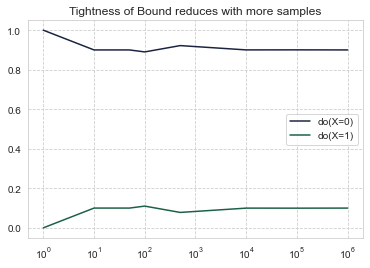

In [368]:
ts_0 = []
ts_1 = []
Ks = [1, 10, 50, 100, 500, 1e4, 1e5, 1e6]
for K in Ks:
    assert(N >= K)
    ps = joint_probs(df[:int(K)], K)
    assert(np.allclose(sum(ps), 1.))
    (l_0, h_0), (l_1, h_1) = compute_bounds(ps)
    t_0 = h_0-l_0 # "tightness of bound"
    t_1 = h_1-l_1
    ts_0.append(t_0)
    ts_1.append(t_1)
    #print(f'(l_0,h_0)=({l_0:.3f},{h_0:.3f})\t (l_1,h_1)=({l_1:.3f},{h_1:.3f})')

plt.plot(Ks, ts_0, label="do(X=0)")
plt.plot(Ks, ts_1, label="do(X=1)")
plt.legend()
plt.title("Tightness of Bound reduces with more samples")
plt.gca().set_xscale('log')
plt.show()

Pretty cool! 

We don't know anything about the structural equations $\mathcal{F}$ in this bound just the base graph implied by the underlying SCM, yet, for $do(X=0)$ we have a very tight bound i.e., we knew a-priori what kind of causal effect to expect in this practical setting.

### This also concludes the Bonus section. I hope you had fun, stay curious, and c ya! `\(*.*)/`

#### Democritus wrote, “I would rather discover one true cause than gain the Kingdom of Persia.”

##### Pearl said, "As X-rays are to the surgeon, graphs are for causation."

*Matej swiftly adapts to, ”As graphs are to the causality, causal nets are for AI.”*

This was my final, personal message. Thanks to all the participants, thanks to all the organizers!